In [1]:
from final_utils import *

In [2]:
root_path = generate_root_path()

## Creating model

In [3]:
def calc_acc(labels, predicted):
    '''
    Calculating mean class error, e.g. predicted classes are 1vs0, 0vs0, 0vs0, 0vs0, then we have acc=0.25
    Inputs: 
        labels = target labels
        predicted = predicted binary probability distribution for the input
    Output:
        mean class error
    '''
    acc = np.sum(np.array(labels) == np.argmax(np.array(predicted), axis=1)) / len(labels)
    return np.round(acc * 100, 2)

In [4]:
#creating feature extractors
model_gap = model_inceptionresnet_multigap()
model_cnn = tf.keras.Sequential([hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",trainable=False) ])

#creating dense and loading the weights
model = fc_model_softmax(input_num=9744)
weights_path = f'models/Softmax/MG_CNN/model_fc_softmax_v1_9744_label.hdf5'
model.load_weights(weights_path)

### Loading PCA models 

In [5]:
# pca_mg_path = 'models/PCA/PCA_MG_8464_auto.pkl'
# pca_cnn_path = 'models/PCA/PCA_CNN_1280_auto.pkl'
# pca_connected_path = 'models/PCA/mgcnn_pca.pkl'

# pca_mg = pk.load(open(pca_mg_path,'rb'))
# pca_cnn =  pk.load(open(pca_cnn_path,'rb'))
# pca_connected = pk.load(open(pca_connected_path,'rb'))

## Giving path of folder

In [6]:
good_imgs_path = glob(os.path.join(root_path, 'Data', 'benchmark', 'images', 'good', '*'))
bad_imgs_path = glob(os.path.join(root_path, 'Data', 'benchmark', 'images', 'bad', '*'))

good_imgs_path_2 = glob(os.path.join(root_path, 'Data', 'benchmark2', 'images', 'good', '*'))
bad_imgs_path_2 = glob(os.path.join(root_path, 'Data', 'benchmark2', 'images', 'bad', '*'))

good_alm_imgs_path = glob(os.path.join(root_path, 'Data','splitted', 'images', 'good', '*'))
bad_alm_imgs_path = glob(os.path.join(root_path, 'Data', 'splitted', 'images', 'bad', '*'))

good_rand_imgs_path = glob(os.path.join(root_path, 'Data', 'custom_data', 'images', 'good', '*'))
bad_rand_imgs_path = glob(os.path.join(root_path, 'Data', 'custom_data', 'images', 'bad', '*'))

bad_coco_imgs_path = glob(os.path.join(root_path, 'Data', 'Coco', 'images', 'bad', '*'))

paths_bench = good_imgs_path + bad_imgs_path
labels_bench = np.concatenate((np.ones(len(good_imgs_path)), np.zeros(len(bad_imgs_path))))

paths_bench_2 = good_imgs_path_2 + bad_imgs_path_2
labels_bench_2 = np.concatenate((np.ones(len(good_imgs_path_2)), np.zeros(len(bad_imgs_path_2))))

paths_alm_bench = good_alm_imgs_path + bad_alm_imgs_path
labels_alm_bench = np.concatenate((np.ones(len(good_alm_imgs_path)), np.zeros(len(bad_alm_imgs_path))))

paths_rand_bench = good_rand_imgs_path + bad_rand_imgs_path
labels_rand_bench = np.concatenate((np.ones(len(good_rand_imgs_path)), np.zeros(len(bad_rand_imgs_path))))

paths_coco_bench = bad_coco_imgs_path
labels_coco_bench = np.zeros(len(bad_coco_imgs_path))

### Some necessary functions for predictions

In [7]:
indxs = np.load('variant1_label_9744.npy')
def take_from_vector(feature_vector, indxs ):    
#     return feature_vector[indxs]
    return np.take(feature_vector, indxs)

In [8]:
def pca_transform(vector, path):
    pca = pk.load(open(path,'rb'))
    return pca.transform(vector)

def predict(x, y=None, model_gap=None, model=None, model_cnn=None, is_norm=False, 
            pca_mg=None, pca_cnn = None, pca_connected = None):
    '''
    Does prediction on given numpy image using
    model_gap and model
    '''
    try:
        feat_mg = model_gap.predict(x, verbose=0)
    except:
        x = x[None] #changed 02.08 for evaluator visualizing predictions
        feat_mg = model_gap.predict(x, verbose=0)
        
    if pca_mg:
        feat_mg = pca_mg.transform(feat_mg)        
    if model_cnn:
        feat_cnn = model_cnn.predict(y, verbose=0)
        if is_norm:
            feat_cnn = normalize_feat_vector(feat_cnn)
        if pca_cnn:
            feat_cnn = pca_cnn.transform(feat_cnn)
            
        feat = np.concatenate((np.squeeze(feat_mg), np.squeeze(feat_cnn)))
        feat = take_from_vector(feat, indxs) 

        feat = feat[None]
    else:
        feat = feat_mg
    pred_score = model.predict(feat, verbose=0)

    return pred_score
    

def predict_from_path(model_gap, model, paths, resize_func=None, size=None, for_all=False, save_results=None, 
                      save_to=None, model_cnn=None, is_norm=False, pca_mg = None, pca_cnn = None, pca_connected=None):
    #always requires list of paths
    predicted = []
    
    for i, path in enumerate(paths):
        img_mg = read_img(path=path, resize_func=resize_func, size=size, for_all=True)
        img_cnn = None
        if model_cnn:
            img_cnn = read_img(path=path, resize_func=resize_add_border, size=(600, 600))
        pred_score = predict(img_mg, img_cnn, model_gap, model, model_cnn, is_norm, pca_mg, pca_cnn, pca_connected)
        predicted.append(pred_score)
    
    predicted = np.array(predicted)
    predicted = np.squeeze(predicted)
    
    if save_results:
        np.save(save_to, np.argmax(predicted, axis=-1))
        
    return predicted

def plot_pred_orig(model_gap, model, imgs_bench, label=None, row_count=2, column_count=10, resize_func=None, size=None,
                   for_all=False, model_cnn=None, is_norm=False, pca_mg=None, pca_cnn=None, pca_connected=None):
    f, axarr = plt.subplots(row_count, column_count,  figsize=(20,5))

    for i, path in enumerate(imgs_bench):
        x = i // column_count
        y = i % column_count

        img_mg = read_img(path, resize_func=resize_func, size=size, for_all=for_all)
        
        img_cnn = None
        if model_cnn:
            img_cnn = read_img(path=path, resize_func=resize_add_border, size=(600, 600))
            
        pred_score = predict(img_mg, img_cnn, model_gap, model, model_cnn, is_norm, pca_mg, pca_cnn, pca_connected)

        im = cv2.imread(path)
        im = cv2.resize(im, (400, 400))
        
        if row_count == 1:
            axarr[i].imshow(im[..., ::-1]) 
            axarr[i].set_title(f'{str(np.argmax(pred_score, axis=-1)[0])}\n{str(np.round(np.max(pred_score, axis=-1),3)[0])}', fontsize=12)
        else:
            axarr[x, y].imshow(im[..., ::-1]) 
            axarr[x, y].set_title(f'{str(np.argmax(pred_score, axis=-1)[0])}\n{str(np.round(np.max(pred_score, axis=-1),3)[0])}', fontsize=12)

    if label:
        f.suptitle('Test on ' + label, fontsize=17)
    else: 
        f.suptitle('Predictions', fontsize=17)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    plt.show()


## Prediction on benchmark

In [9]:
#resize_max (996, 996) means if images' height or width > 996 then resize with maximum 996 and another with aspect ratio
predicted = predict_from_path(model_gap, model, paths_bench, resize_func=resize_max, 
                              size=(996, 996), for_all=False, model_cnn=model_cnn, is_norm=False)

In [10]:
acc = calc_acc(labels_bench, predicted)
print(f'Accuracy: {acc} %')

Accuracy: 82.88 %


In [11]:
#Precision and Recall
pred = np.argmax(predicted, axis=1)
calc_metrics(labels_bench, pred)

Precision: 75.0 %
Recall: 89.36 %


## Prediction on benchmark 2

In [12]:
predicted = predict_from_path(model_gap, model, paths_bench_2, resize_func=resize_max, 
                              size=(996, 996), for_all=False, model_cnn=model_cnn, is_norm=False)

In [13]:
acc = calc_acc(labels_bench_2, predicted)
print(f'Accuracy: {acc} %')

Accuracy: 88.01 %


In [14]:
#Precision and Recall
pred = np.argmax(predicted, axis=1)
calc_metrics(labels_bench_2, pred)

Precision: 82.85 %
Recall: 96.82 %


# Prediction on Coco

In [15]:
predicted = predict_from_path(model_gap, model, paths_coco_bench, resize_func=resize_max, 
                              size=(996, 996), for_all=True, model_cnn=model_cnn, is_norm=False)

In [16]:
acc = calc_acc(labels_coco_bench, predicted)
print(f'Accuracy: {acc} %')

Accuracy: 94.7 %


## Prediction on benchmark

In [17]:
predicted = predict_from_path(model_gap, model, paths_alm_bench, resize_func=resize_max, 
                              size=(996, 996), for_all=False, model_cnn=model_cnn, is_norm=False)

In [18]:
acc = calc_acc(labels_alm_bench, predicted)
print(f'Accuracy: {acc} %')

Accuracy: 92.5 %


In [19]:
#Precision and Recall
pred = np.argmax(predicted, axis=1)
calc_metrics(labels_alm_bench, pred)

Precision: 88.29 %
Recall: 98.0 %


## Prediction on custom data

In [20]:
predicted = predict_from_path(model_gap, model, paths_rand_bench, resize_func=resize_max, 
                              size=(996, 996), for_all=False, model_cnn=model_cnn, is_norm=False)

In [21]:
acc = calc_acc(labels_rand_bench, predicted)
print(f'Accuracy: {acc} %')

Accuracy: 95.0 %


In [22]:
#Precision and Recall
pred = np.argmax(predicted, axis=1)
calc_metrics(labels_rand_bench, pred)

Precision: 93.27 %
Recall: 97.0 %


## Visualizing predictions on benchmark

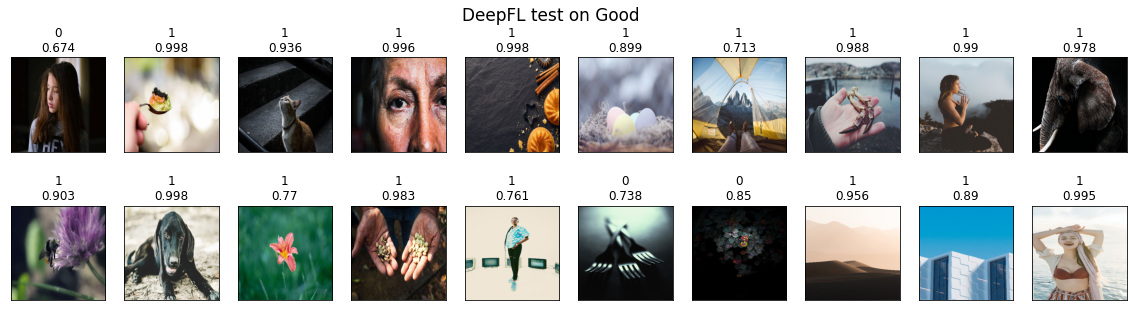

In [23]:
data_size = 20
plot_pred_orig(model_gap, model, good_imgs_path[:data_size], resize_func=resize_max, 
               label='Good', size=(996, 996), for_all=False, model_cnn=model_cnn, is_norm=False)

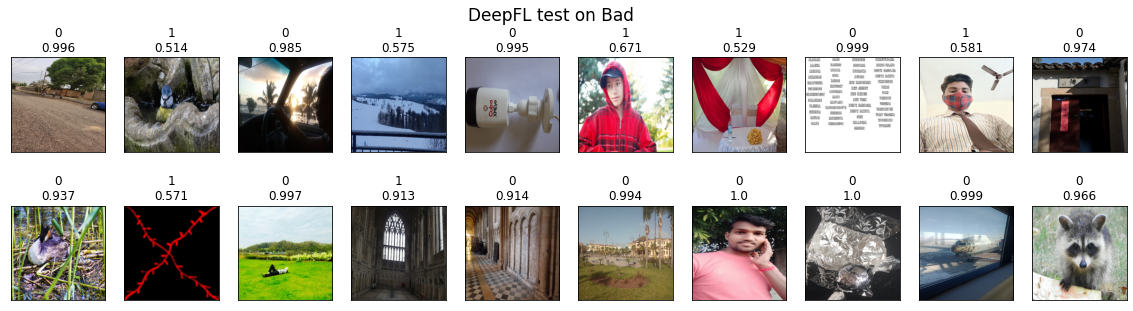

In [24]:
data_size = 20
plot_pred_orig(model_gap, model, bad_imgs_path[:data_size], resize_func=resize_max, 
              label='Bad', size=(996, 996), for_all=False, model_cnn=model_cnn, is_norm=False)

## Visualizing predictions on benchmark2

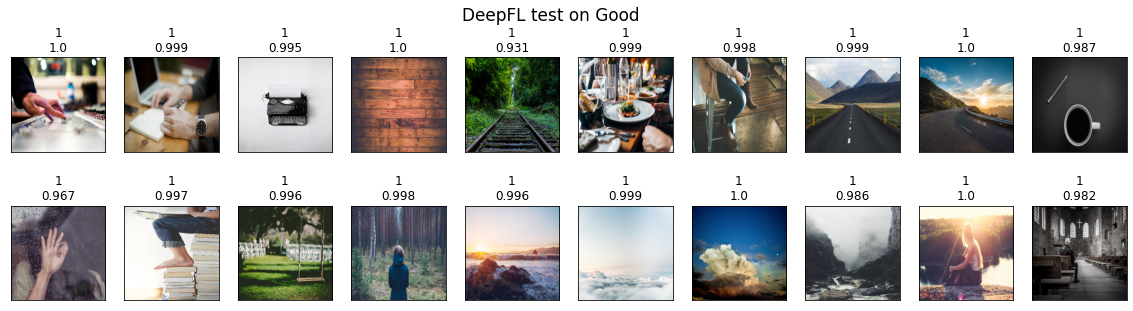

In [25]:
data_size = 20
plot_pred_orig(model_gap, model, good_imgs_path_2[:data_size], resize_func=resize_max, 
               label='Good', size=(996, 996), for_all=False, model_cnn=model_cnn, is_norm=False)

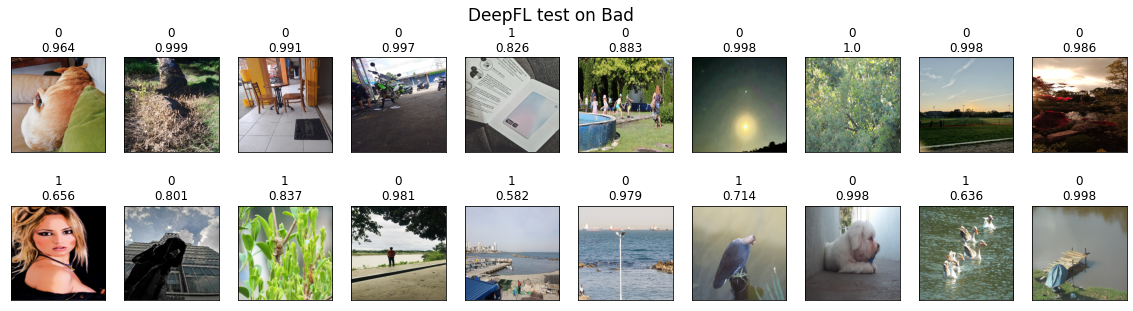

In [26]:
data_size = 20
plot_pred_orig(model_gap, model, bad_imgs_path_2[:data_size], resize_func=resize_max, 
               label='Bad', size=(996, 996), for_all=False, model_cnn=model_cnn, is_norm=False)

## Visualizing predictions on Coco


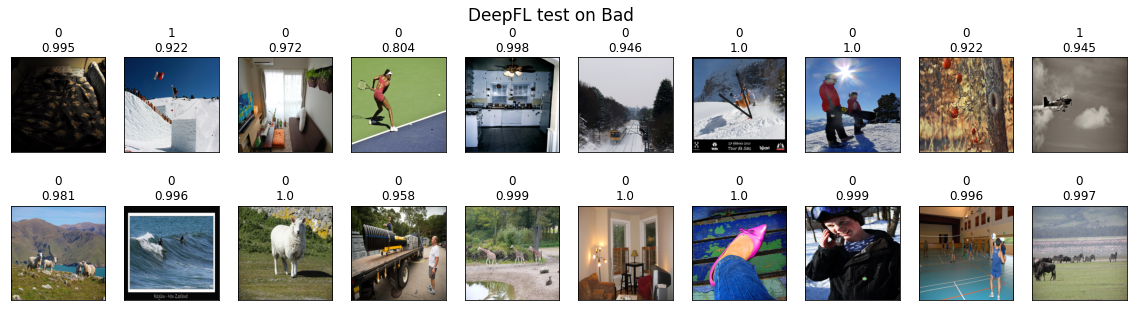

In [27]:
data_size = 20
plot_pred_orig(model_gap, model, bad_coco_imgs_path[80:100], resize_func=resize_max, 
               label='Bad', size=(996, 996), for_all=True, model_cnn=model_cnn, is_norm=False)